In [2]:
# load libraries
import xarray as xr
from minisom import MiniSom
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler, scale
import numpy as np


# SOM Spatio-Temporal Example

## Open and Explore data

Air temperature data from the US

In [3]:
# open xarray tutorial dataset
ds = xr.tutorial.open_dataset("air_temperature.nc").rename({"air": "Tair"})
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    Tair     (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...


In [3]:
print(ds.description)

Data is from NMC initialized reanalysis
(4x/day).  These are the 0.9950 sigma level values.


(array([   2182.,   60537.,  195026.,  233763.,  315219.,  635948.,
         778807., 1192236.,  453381.,    1901.]),
 array([221.     , 230.64   , 240.28   , 249.92   , 259.56   , 269.2    ,
        278.84   , 288.47998, 298.12   , 307.76   , 317.4    ],
       dtype=float32),
 <a list of 10 Patch objects>)

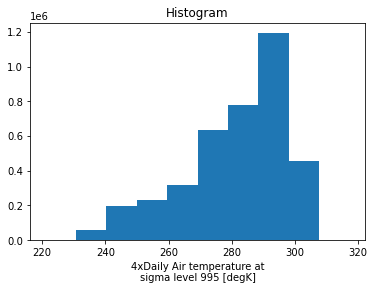

In [4]:
# plot histogram
ds.Tair.plot()

Histogram plot of air temperature. Data seems to have a skewed distribution (not normally distributed)

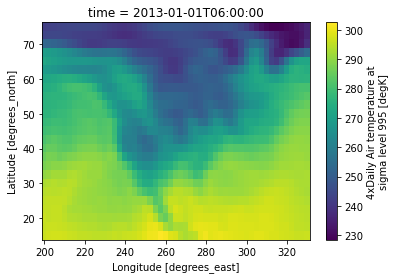

In [5]:
# plot at initial time
ds.Tair.isel(time=1).plot()

Plot of Air temperature at the first measurement (jan 2013). The difference in air temperature over land and ocean is clear, with the shape of North America visible in the plot. Note: temperature is given in degrees Kelvin. 

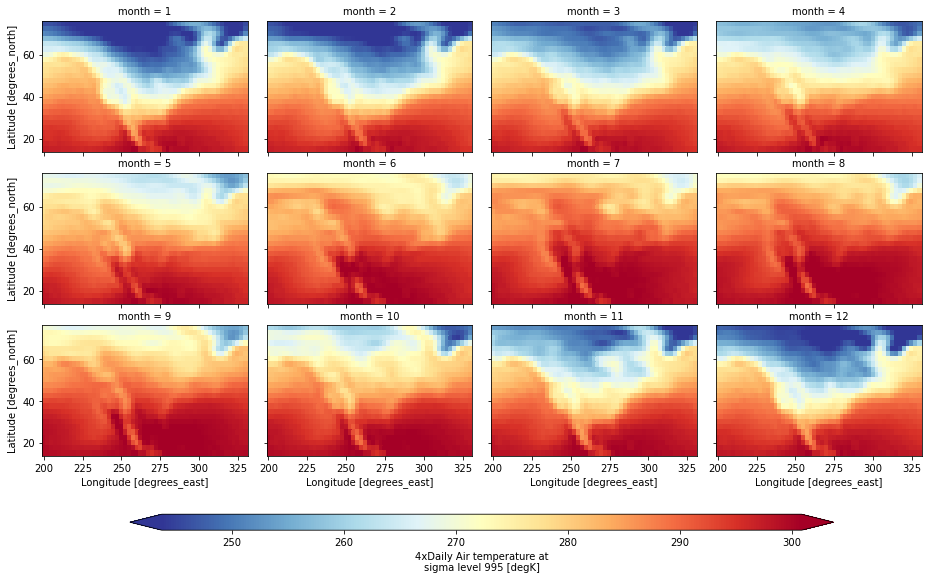

In [6]:
# group by month and plot it:
monthly_means = ds.groupby("time.month").mean()
# xarray's groupby reductions drop attributes. Let's assign them back so we get nice labels.
monthly_means.Tair.attrs = ds.Tair.attrs

fg = monthly_means.Tair.plot(
    col="month",
    col_wrap=4,  # each row has a maximum of 4 columns
        # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlBu_r,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
    },
)


Monthly mean air temperature. Visible increase of temperature during the summer months (month 6-9 (jun-sept, summer in North Hermisphere)), and decrease of temperature during winter. 

# SOM Clustering

In [7]:
# define SOM parameters
som_map = (3,3) # we will try a 3x3 neural map
x,y=som_map
sigma = 1 # default value
learning_rate = 0.5 # default value
ngb_function = 'gaussian' # choosing between ['gaussian' ,'bubble','mexican_hat']
init = 'random' # we will initialize SOM randomly. Option: 'pca'
train = 'batch' # perform batch traning instead of random (default)
iterations = 10000 # lenght of training
topology = 'hexagonal' # to ensure equidistant ditance neighbors
activation_distance = 'euclidean'

In [8]:
# data params
data_in=np.array(ds['Tair'])
dimlon=len(ds['lon'])
dimlat= len(ds['lat'])
dimtime = len(ds['time'])

Most SOM tutorials are found on image classification (see the tree example). 
Let's try applying SOM to the mean field first:

Text(0.5, 1.0, 'Mean Air Temperature')

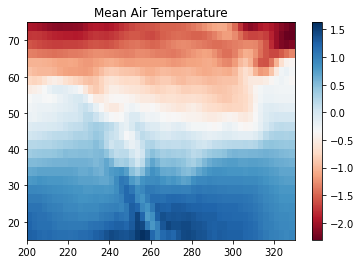

In [9]:
data = np.nanmean(data_in,axis=0)
# normalize data
data = (data - np.nanmean(data, axis=0)) / np.nanstd(data, axis=0)
plt.pcolor(ds.lon,ds.lat,data,
          cmap='RdBu',
           # vmin=-300,vmax=300
          )
plt.colorbar()
plt.title('Mean Air Temperature')
plt.show()

Mean air temperature anomaly ver the years 2013 and 2014. Data is normalized to have 1 unit standard deviation. 

In [10]:
X=np.array(data)
input_len=X.shape[1]

# create som
som = MiniSom(x=x,y=y,input_len=input_len,
                    sigma=sigma,learning_rate=learning_rate,
                    neighborhood_function=ngb_function,
                    topology=topology,
                    activation_distance=activation_distance,
                    random_seed=None)
# init som
if init=='pca':
    som.pca_weights_init(X)
else:
    som.random_weights_init(X)

# train som
if train=='random':
    som.train_random(X,iterations,verbose=True)
else:
    som.train_batch(X,iterations,verbose=True)

 [  1835 / 10000 ]  18% - 0:00:00 left 

 [  3055 / 10000 ]  31% - 0:00:00 left 

 [  4481 / 10000 ]  45% - 0:00:00 left 

 [  5832 / 10000 ]  58% - 0:00:00 left 

 [  7217 / 10000 ]  72% - 0:00:00 left 

 [  8575 / 10000 ]  86% - 0:00:00 left 

 [  9829 / 10000 ]  98% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.9535273382870869


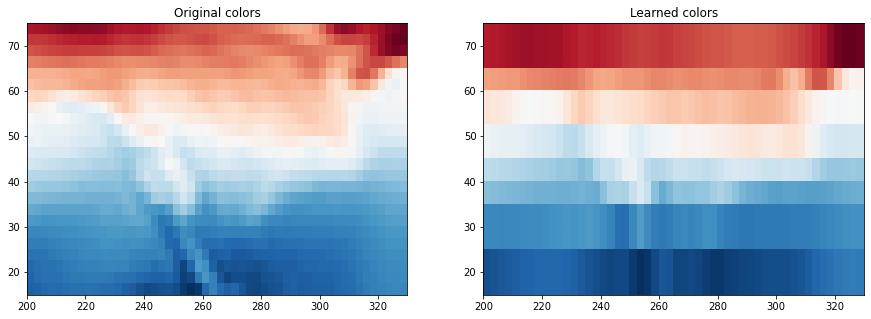

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title('original')
plt.pcolor(ds.lon,ds.lat,X,
          cmap='RdBu',)
plt.title('Original colors')
plt.subplot(122)
plt.pcolor(ds.lon,ds.lat,som.quantization(X),
          cmap='RdBu',)
plt.title('Learned colors')
plt.show()

On the right we have the original plot, and on the left the learned colors from SOM quantizaton

# 3D SOM
Now, let's use the entire 3D matrix (time,lat,lon).

We will apply SOM first on time domain, that is, find spatial clusters that are correlated in time, and later in spatial domain. 

In [12]:
data=np.array(data_in)
print(data_in.shape)

(2920, 25, 53)


In [13]:
# data preprocessing

# we need to concatenate the dataset to 2D:
data=data_in.reshape(dimtime,dimlat*dimlon)

# normalize dataset:
# using MinMaxScaler
# sc = MinMaxScaler (feature_range = (0,1))
# data_norm = sc.fit_transform (data)
# scale data
# X_scale= scale(data.T)
# manually
data = (data - np.nanmean(data, axis=0)) / np.nanstd(data, axis=0)


## Time domain

In [14]:
# to analyse in time domain we need to transpose it:
X = data.T
input_len=X.shape[1]

# create som
som = MiniSom(x=x,y=y,input_len=input_len,
                    sigma=sigma,learning_rate=learning_rate,
                    neighborhood_function=ngb_function,
                    topology=topology,
                    activation_distance=activation_distance,
                    random_seed=None)
# init som
if init=='pca':
    som.pca_weights_init(X)
else:
    som.random_weights_init(X)

# train som
if train=='random':
    som.train_random(X,iterations,verbose=True)
else:
    som.train_batch(X,iterations,verbose=True)

 [   499 / 10000 ]   5% - 0:00:02 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 29.1143042357806


### Clusters of different temporal variability
Considering the time series 3x3 SOM analysis

Requested network: 3x3
 Identified: 9 regions


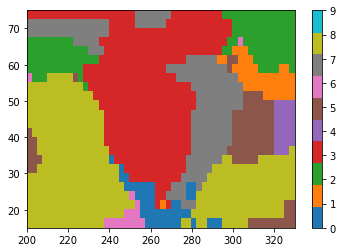

In [15]:
# extract clusters of winning neurons:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in X]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, (x,y))
# cluster_index=winner_coordinates[1,:]
n_cluster=len(np.unique(cluster_index))
print('Requested network: {}x{}\n Identified: {} regions'.format(x,y,n_cluster))
plt.pcolor(ds.lon,ds.lat,cluster_index.reshape(dimlat,dimlon),
           vmin=0,vmax=x*y,cmap='tab10');
plt.colorbar()
plt.show()

The above image shows the clusters identified when analyzing the spatial temperature fields through time. 
We see a dominant cluster of Air temperature over the US continent, and the smaller clusters over the ocean which agree with the main atmospheric circulation pattern. 

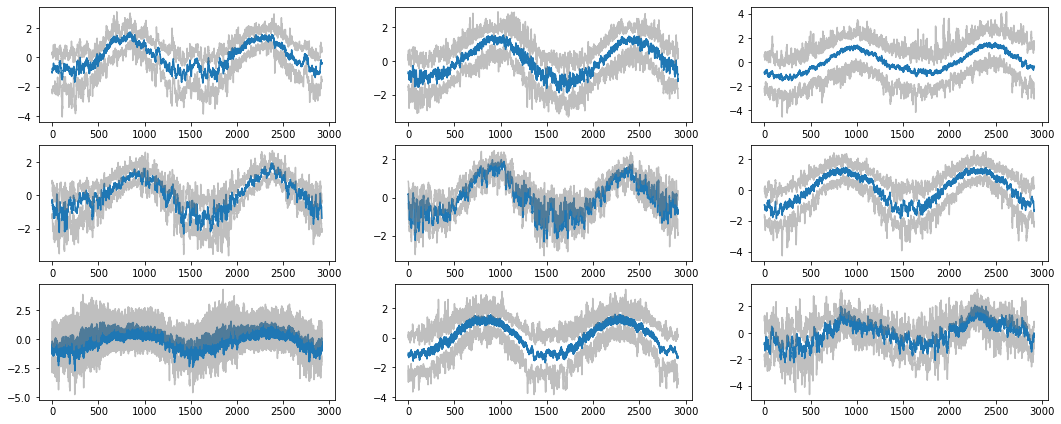

In [16]:
# extract time series of each cluster
win_map = som.win_map(X)
win_ts=np.zeros((len(win_map),input_len,3))
# cluster_index = np.ravel_multi_index(win_ts, (x,y))

# plto time series
plt.figure(figsize=(50, 20))
the_grid = GridSpec(8, 8)

for i,position in enumerate(win_map.keys()):
    win_ts[i,:,0]=np.min(win_map[position], axis=0) 
    win_ts[i,:,1]=np.mean(win_map[position], axis=0)
    win_ts[i,:,2]=np.max(win_map[position], axis=0)
    
    plt.subplot(the_grid[6-position[1], position[0]])
    plt.plot(np.min(win_map[position], axis=0), color='gray', alpha=.5)
    plt.plot(np.mean(win_map[position], axis=0))
    plt.plot(np.max(win_map[position], axis=0), color='gray', alpha=.5)
    
plt.show()

Mean (blue), max and min (in grey) time series of each cluster. 

## Space domain

In [17]:
# to analyse in time domain we need to transpose it:
X = data
input_len=X.shape[1]

# create som
som = MiniSom(x=x,y=y,input_len=input_len,
                    sigma=sigma,learning_rate=learning_rate,
                    neighborhood_function=ngb_function,
                    topology=topology,
                    activation_distance=activation_distance,
                    random_seed=None)
# init som
if init=='pca':
    som.pca_weights_init(X)
else:
    som.random_weights_init(X)

# train som
if train=='random':
    som.train_random(X,iterations,verbose=True)
else:
    som.train_batch(X,iterations,verbose=True)

 [   892 / 10000 ]   9% - 0:00:02 left 

 [  1828 / 10000 ]  18% - 0:00:01 left 

 [  2772 / 10000 ]  28% - 0:00:01 left 

 [  3718 / 10000 ]  37% - 0:00:01 left 

 [  4632 / 10000 ]  46% - 0:00:01 left 

 [  5483 / 10000 ]  55% - 0:00:00 left 

 [  6451 / 10000 ]  65% - 0:00:00 left 

 [  7346 / 10000 ]  73% - 0:00:00 left 

 [  8081 / 10000 ]  81% - 0:00:00 left 

 [  8955 / 10000 ]  90% - 0:00:00 left 

 [  9890 / 10000 ]  99% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 23.971422068680223


In [18]:
# extract clusters of winning neurons:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in X]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, (x,y))
# cluster_index=winner_coordinates[1,:]
n_cluster=len(np.unique(cluster_index))
print('Requested network: {}x{}\n Identified: {} regions'.format(x,y,n_cluster))
# plt.pcolor(ds.lon,ds.lat,cluster_index.reshape(dimlat,dimlon),
#           vmin=0,vmax=x*y,cmap='tab10');
# plt.colorbar()
# plt.show()

Requested network: 3x3
 Identified: 9 regions


### Spatial patterns of a 3x3 SOM

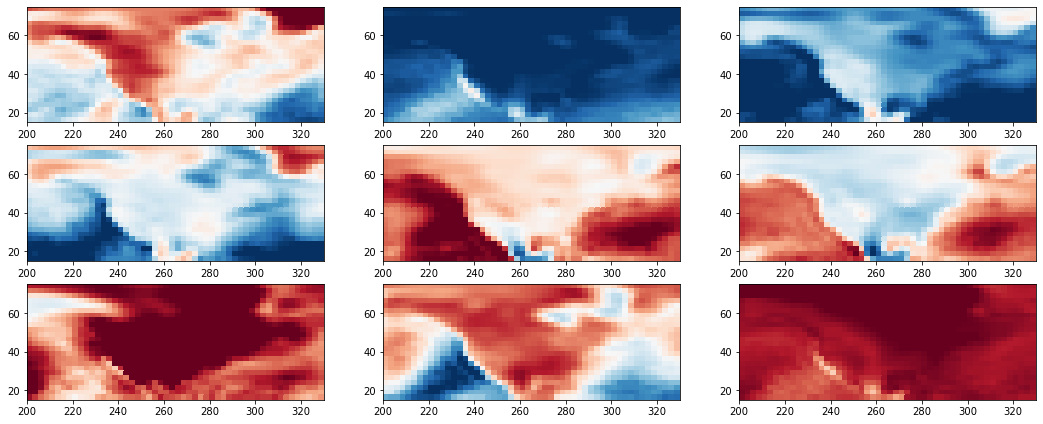

In [21]:
# extract results
win_map = som.win_map(data)
win_ts=np.zeros((len(win_map),input_len,3))
# cluster_index = np.ravel_multi_index(win_ts, (x,y))

plt.figure(figsize=(50, 20))
the_grid = GridSpec(8,8)

for i,position in enumerate(win_map.keys()):
    win_ts[i,:,0]=np.min(win_map[position], axis=0)
    win_ts[i,:,1]=np.mean(win_map[position], axis=0)
    win_ts[i,:,2]=np.max(win_map[position], axis=0)

    
    # plt.plot(win_ts[:,:,0].T);plt.show()
    # plot spatial pattern of each neuron
    plt.subplot(the_grid[6-position[1], position[0]])
    plt.pcolor(ds.lon,ds.lat,win_ts[i,:,1].reshape(dimlat,dimlon),
              cmap='RdBu',vmin=-1,vmax=1);
plt.show()

The above image shows the spatial patterns of the dominant time periods, when we make the SOM analyses over space, instead of time. SOM algorithm will find the most dominant patterns (instead of the most dominant time series, like previously). 

# Reference

Hernandez-Carrasco, I., & Orfila, A. (2018). The role of an intense front on the connectivity of the western Mediterranean Sea: The Cartagena- Tenes front. Journal of Geophysical Research: Oceans, 123, 4398–4422. https://doi.org/10.1029/2017JC013613